<a href="https://colab.research.google.com/github/masaichig0/TensorFlow-deeplearning/blob/main/07_food_vision_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

# Milestone Project 1: Food Vision Big

## Check GPU

* Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training. 

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tessla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-00fc50b0-2808-06d5-49c8-d1e6c615d7cb)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-08 17:29:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-08 17:29:12 (95.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

TensorFlow Dataset overview: https://www.tensorflow.org/datasets

In [ ]:
# Get Tesorflow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets

True


In [ ]:
# Load in the data (takes 5-6 minutes in google colab)
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, lable)
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteXUKL3P/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteXUKL3P/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the food 101 data from TensorFlow Datasets

To become one with our data,  we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output infor about in training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image, label, train_one_sample

(<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
 array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [144,  81, 102],
         [142,  78, 102],
         [139,  75,  99]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [159,  96, 115],
         [154,  89, 111],
         [146,  83, 104]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [162,  98, 114],
         [162,  95, 113],
         [157,  93, 110]],
 
        ...,
 
        [[ 75,  32,  16],
         [ 77,  34,  17],
         [ 78,  35,  19],
         ...,
         [ 99,  31,  20],
         [104,  32,  20],
         [106,  34,  20]],
 
        [[ 81,  34,  18],
         [ 81,  34,  16],
         [ 82,  35,  19],
         ...,
         [102,  33,  26],
         [104,  36,  27],
         [109,  39,  31]],
 
        [[ 79,  30,  13],
         [ 80,  31,  14],
         [ 81,

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow

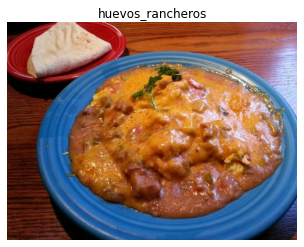

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to varify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data: 
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224, scaled=False):
  """
  Converts image datatype from `uint8` -> `float32` and reshapes
  image to [img_shape, img_shape, colour_channels]
  If the images needed to scale, set the `scaled=True`
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # resize target image
  if scaled:
    image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:/n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:/n [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  81 102]
  [142  78 102]
  [139  75  99]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [159  96 115]
  [154  89 111]
  [146  83 104]]]..., 
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.23973   91.24997  110.18368 ]
  [150.2857    86.622444 107.239784]
  [144.57637   80.47435  103.6325  ]]

 [[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.85226   91.70941  105.097206]
  [164.45404   97.72448  114.3112  ]
  [159.09677   93.16319  110.545815]]]..., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare dataset

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
# map preprocessing functon to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch  it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize the later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during trainig
checkpoint_path_1 = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_1,
                                                      monitor="val_acc",
                                                      save_best_onnluy=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precison:https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data tyype to speed up model performance.

Single precison floating point: https://en.wikipedia.org/wiki/Single-precision_floating-point_format

In [ ]:
# Turn on mixed precison training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_shape")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't, you can have a leyer like below
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# compile model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precisin?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_shape True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not(if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer stores its variables in 
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen).
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the model
history_base = model.fit(train_data,
                         epochs=3,
                         steps_per_epoch=(len(train_data)),
                         validation_data=test_data,
                         validation_steps=int(0.15*len(test_data)),
                         callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                experiment_name="efficientnetb0_base"),
                                    model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_base/20210708-174123
Epoch 1/3
2368/2368 [==============================] - 221s 77ms/step - loss: 2.3170 - accuracy: 0.4677 - val_loss: 1.2467 - val_accuracy: 0.6727
Epoch 2/3
2368/2368 [==============================] - 163s 68ms/step - loss: 1.3131 - accuracy: 0.6611 - val_loss: 1.1299 - val_accuracy: 0.7005
Epoch 3/3
2368/2368 [==============================] - 162s 68ms/step - loss: 1.1404 - accuracy: 0.7031 - val_loss: 1.0922 - val_accuracy: 0.7060


In [ ]:
# Evaluate the model
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 55s 70ms/step - loss: 1.0879 - accuracy: 0.7059


[1.0878722667694092, 0.7059406042098999]

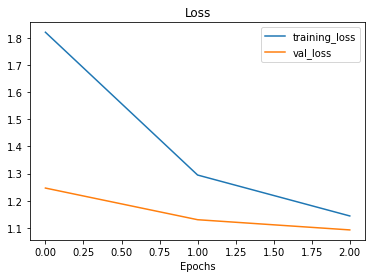

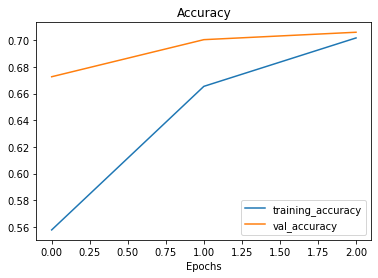

In [ ]:
plot_loss_curves(history_base)

In [ ]:
# Clone the model we created 
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# where are checkpoint stored?
checkpoint_path_1

'model_checkpoint/cp.ckpt'

In [ ]:
cloned_model.load_weights(checkpoint_path_1)

In [ ]:
cloned_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
results_clone_model_loaded_weights = cloned_model.evaluate(test_data)
results_clone_model_loaded_weights

790/790 [==============================] - 49s 59ms/step - loss: 1.0944 - accuracy: 0.7017


[1.0878722667694092, 0.7059406042098999]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

In [ ]:
# Save the model to the google drive
import os
save_dir = "/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_percision/"
os.makedirs(save_dir)

model.save(save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_percision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_percision/assets


In [ ]:
loaded_save_model = tf.keras.models.load_model(save_dir)

In [ ]:
# evaluate the loaded model to check
results_loaded_saved_model = loaded_save_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 48s 59ms/step - loss: 1.0879 - accuracy: 0.7059


[1.087871789932251, 0.7059406042098999]

## Save the whole model to the file

In [ ]:
# Save the model to google colab
model.save("big_data_efficientnetb0_base_07.h5")

In [ ]:
loaded_model = tf.keras.models.load_model("big_data_efficientnetb0_base_07.h5")

In [ ]:
results_loaded_model = loaded_model.evaluate(test_data)
results_loaded_model

790/790 [==============================] - 48s 59ms/step - loss: 1.0889 - accuracy: 0.7051


[1.088898777961731, 0.7050693035125732]

790/790 [==============================] - 56s 70ms/step - loss: 1.0889 - accuracy: 0.7051

[1.0888983011245728, 0.7050693035125732]

In [ ]:
for layer in loaded_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_shape True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in loaded_model.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">


## Prepare model's layers for fine-tuning

Experiment fine-tuning:
* 50 trainable layers
* 100 epochs (setup EarlyStopping Callbacks if result doesn't increase after 3 epochs)

In [ ]:
# download model from Daniel's github page
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2021-07-08 18:04:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.08s   

2021-07-08 18:04:20 (192 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# unzip the savedModel downloaded from google strage
!mkdir downloaded_gs_model # create the new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
gs_model_results = loaded_gs_model.evaluate(test_data)
gs_model_results

790/790 [==============================] - 49s 60ms/step - loss: 1.0881 - accuracy: 0.7066


[1.088120460510254, 0.7065742611885071]

**My model result:**

790/790 [==============================] - 48s 59ms/step - loss: 1.0889 - accuracy: 0.7051

[1.088898777961731, 0.7050693035125732]


In [ ]:
# Create ModelCheckpoint
checkpoint_path_2 = "fine_tune_checkpoint/"
fine_tune_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_2,
                                                          save_best_only=True,
                                                          save_weights_only=True)

# Create earlystopping callbacks
earlystopping_callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3,)

In [ ]:
# Create learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # printout when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# compile the model
loaded_gs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=['accuracy'])

In [ ]:
for i, layer in enumerate(loaded_gs_model.layers[1].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
len(loaded_gs_model.layers[1].trainable_variables)

211

In [ ]:
# Fit the model
history_fine_tune_1 = loaded_gs_model.fit(train_data,
                                          epochs=100, # fine-tune for maximum of 100 epochs
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                experiment_name='efficientnetb0_fine_tune_1'),
                                                    fine_tune_checkpoint,
                                                    earlystopping_callbacks,
                                                     reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb0_fine_tune_1/20210708-181440
Epoch 1/100
2368/2368 [==============================] - 307s 124ms/step - loss: 0.9880 - accuracy: 0.7348 - val_loss: 0.8056 - val_accuracy: 0.7805
Epoch 2/100
2368/2368 [==============================] - 292s 123ms/step - loss: 0.5799 - accuracy: 0.8389 - val_loss: 0.7838 - val_accuracy: 0.7926
Epoch 3/100
2368/2368 [==============================] - 292s 123ms/step - loss: 0.3314 - accuracy: 0.9090 - val_loss: 0.8394 - val_accuracy: 0.7881
Epoch 4/100
2368/2368 [==============================] - 291s 122ms/step - loss: 0.1715 - accuracy: 0.9499 - val_loss: 0.9661 - val_accuracy: 0.7810

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 290s 122ms/step - loss: 0.0488 - accuracy: 0.9886 - val_loss: 1.0444 - val_accuracy: 0.8064


## load final model from google drive and predict 


In [ ]:
# save model to google drive
loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/efficientnetb0_fine_tune_gs_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/efficientnetb0_fine_tune_gs_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/efficientnetb0_fine_tune_gs_model/assets


In [ ]:
# save model
loaded_gs_model.save("big_data_efficientnetb0_fine_tune_gs_model")

INFO:tensorflow:Assets written to: big_data_efficientnetb0_fine_tune_gs_model/assets


INFO:tensorflow:Assets written to: big_data_efficientnetb0_fine_tune_gs_model/assets


In [ ]:
# evaluate the model
results_fine_tuned_gs_model = loaded_gs_model.evaluate(test_data)
results_fine_tuned_gs_model

790/790 [==============================] - 48s 60ms/step - loss: 1.0591 - accuracy: 0.7989


[1.0590835809707642, 0.7989307045936584]

In [ ]:
# load fine tuned model
final_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/food_vision/efficientnetb0_fine_tune_gs_model")

In [ ]:
# evaluate the final model to check the results are the same as saved model
final_model_results = final_model.evaluate(test_data)
final_model_results

790/790 [==============================] - 48s 58ms/step - loss: 1.0591 - accuracy: 0.7989


[1.0590827465057373, 0.7989307045936584]

In [ ]:
# view training results on Tensorboard
!tensorboard dev upload --logdir ./training_logs \
--name "Fine-tuning EfficientNetB0 on all Food101 Data" \
--description "Training results for fine-tuning EfficientNetB0 on Food101 data with learning rate 0.0001" \
--one_shot

View TensorBoard results at: https://tensorboard.dev/experiment/jaqixy8MREGnzNBjM5sNXg/

In [ ]:
!tensorboard dev list

## Predict the results with `final_model` and visualize them

Set the test_data with no shuffling

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-07-08 19:13:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   225MB/s    in 7.9s    

2021-07-08 19:13:52 (196 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
from helper_functions import unzip_data
# unzip_data("/content/101_food_classes_10_percent.zip")

test_dir = "/content/101_food_classes_10_percent/test"
tf.random.set_seed(42)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224, 224),
                                                                shuffle=False)

Found 25250 files belonging to 101 classes.


In [ ]:
pred_probs = final_model.predict(test_data, verbose=1)

790/790 [==============================] - 93s 118ms/step


In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([85,  0,  0,  0,  0,  0,  0,  0,  0, 41])

In [ ]:
y_labels = []
for image, label in test_data.unbatch():
  y_labels.append(label.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
final_model_results

[1.0590827465057373, 0.7989307045936584]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
accuracy_score = accuracy_score(y_labels, pred_classes)
accuracy_score

0.7837623762376238

In [ ]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       250
           1       0.82      0.73      0.77       250
           2       0.84      0.87      0.85       250
           3       0.82      0.84      0.83       250
           4       0.68      0.78      0.73       250
           5       0.70      0.69      0.70       250
           6       0.84      0.84      0.84       250
           7       0.92      0.90      0.91       250
           8       0.66      0.60      0.63       250
           9       0.84      0.65      0.73       250
          10       0.70      0.78      0.74       250
          11       0.85      0.83      0.84       250
          12       0.87      0.84      0.86       250
          13       0.73      0.82      0.77       250
          14       0.80      0.80      0.80       250
          15       0.65      0.69      0.67       250
          16       0.01      0.01      0.01       250
          17       0.01    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

f1_scores_df = pd.DataFrame({'class_name': list(class_f1_scores.keys()),
                             'f1-score': list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores_df.tail()

,class_name,f1-score
22,chocolate_mousse,0.600390
39,foie_gras,0.595937
93,steak,0.484848
16,cheesecake,0.011742
17,cheese_plate,0.007843


Load weights and do another fine-tune from the Checkpoint.

`model.load_weights(checkpoint_path_1)`


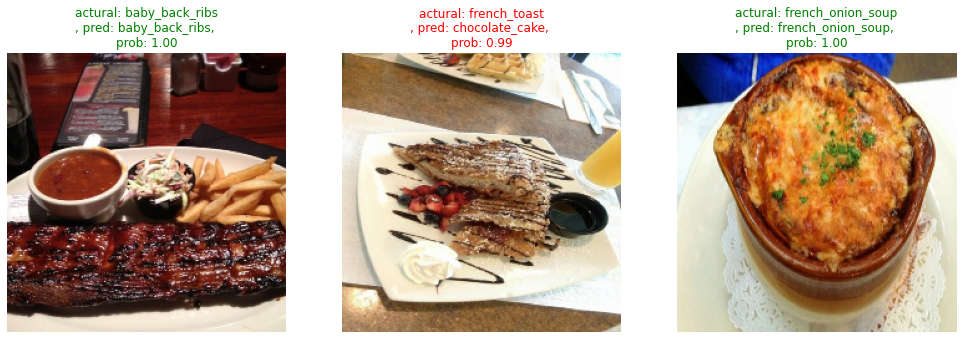

In [ ]:
from helper_functions import load_and_prep_image

import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename
  
  # Load the image and make prediction
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = final_model.predict(tf.expand_dims(img, axis=0)) # Get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index and match it class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i +1)
  plt.imshow(img/255.)
  if class_name == pred_class: # If predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actural: {class_name}\n, pred: {pred_class}, \nprob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
# Finding most wrong predictions
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        'pred_conf': pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.sample(10)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
21441,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.819445,samosa,spring_rolls
18725,b'/content/101_food_classes_10_percent/test/pe...,74,74,0.999945,peking_duck,peking_duck
4083,b'/content/101_food_classes_10_percent/test/ch...,16,17,0.999982,cheesecake,cheese_plate
144,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.960171,apple_pie,apple_pie
10023,b'/content/101_food_classes_10_percent/test/fr...,40,40,0.999976,french_fries,french_fries
13164,b'/content/101_food_classes_10_percent/test/gy...,52,87,0.999649,gyoza,scallops
21135,b'/content/101_food_classes_10_percent/test/ri...,84,89,0.677575,risotto,shrimp_and_grits
19962,b'/content/101_food_classes_10_percent/test/pr...,79,79,1.000000,prime_rib,prime_rib
13464,b'/content/101_food_classes_10_percent/test/ha...,53,53,0.999109,hamburger,hamburger
11244,b'/content/101_food_classes_10_percent/test/fr...,44,44,0.999998,fried_rice,fried_rice


In [ ]:
# Find out which predictions are wrong
pred_df["pred_correct"] = pred_df['y_true'] == pred_df["y_pred"]
pred_df.sample(10)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
5560,b'/content/101_food_classes_10_percent/test/ch...,22,22,0.990684,chocolate_mousse,chocolate_mousse,True
22454,b'/content/101_food_classes_10_percent/test/sh...,89,89,0.839458,shrimp_and_grits,shrimp_and_grits,True
13794,b'/content/101_food_classes_10_percent/test/ho...,55,55,0.999974,hot_dog,hot_dog,True
8577,b'/content/101_food_classes_10_percent/test/eg...,34,10,0.701474,eggs_benedict,bruschetta,False
4129,b'/content/101_food_classes_10_percent/test/ch...,16,17,0.957766,cheesecake,cheese_plate,False
10901,b'/content/101_food_classes_10_percent/test/fr...,43,43,0.999999,fried_calamari,fried_calamari,True
5990,b'/content/101_food_classes_10_percent/test/ch...,23,23,0.999999,churros,churros,True
19986,b'/content/101_food_classes_10_percent/test/pr...,79,79,0.966105,prime_rib,prime_rib,True
12107,b'/content/101_food_classes_10_percent/test/gr...,48,48,0.999991,greek_salad,greek_salad,True
8129,b'/content/101_food_classes_10_percent/test/du...,32,32,0.999534,dumplings,dumplings,True


In [ ]:
wrong_pred = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)
wrong_pred.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
4177,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4223,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4245,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4242,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4237,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4007,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4130,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4158,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4156,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False
4228,b'/content/101_food_classes_10_percent/test/ch...,16,17,1.0,cheesecake,cheese_plate,False


In [ ]:
pd.set_option("display.max_row", None)
wrong_pred.value_counts('y_true_classname')

y_true_classname
cheese_plate               248
cheesecake                 247
steak                      130
foie_gras                  118
bread_pudding               99
apple_pie                   98
chocolate_mousse            96
filet_mignon                93
breakfast_burrito           88
risotto                     87
pork_chop                   86
huevos_rancheros            86
tuna_tartare                85
ravioli                     85
chocolate_cake              84
crab_cakes                  83
lasagna                     83
omelette                    79
ceviche                     77
beet_salad                  77
scallops                    76
chicken_curry               72
grilled_salmon              72
gnocchi                     70
tacos                       70
french_toast                68
baby_back_ribs              67
hummus                      66
panna_cotta                 66
grilled_cheese_sandwich     66
tiramisu                    63
shrimp_and_grits      

In [ ]:
cheese_plate = wrong_pred[wrong_pred["y_true_classname"] == "cheese_plate"]
cheese_cake = wrong_pred[wrong_pred["y_true_classname"] == "cheesecake"]

In [ ]:
# Accuracy must match with following calculation
ratio_wrong_pred = 1 - wrong_pred.shape[0] / len(pred_df)
print(f"accuracy score: {accuracy_score}\n wrong pred ratio: {ratio_wrong_pred}")

accuracy score: 0.7837623762376238
 wrong pred ratio: 0.7837623762376238


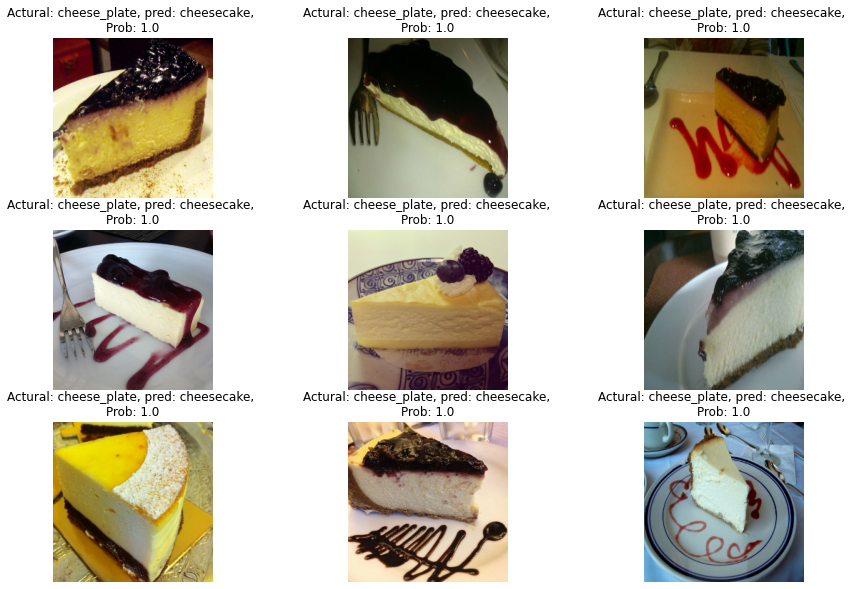

In [ ]:
# Visualize the test data samples which have wrong prediction 
image_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(cheese_plate[start_index:start_index+image_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _,_,_,_,pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"Actural: {y_true_classname}, pred: {y_pred_classname}, \nProb: {pred_prob}")
  plt.axis(False)

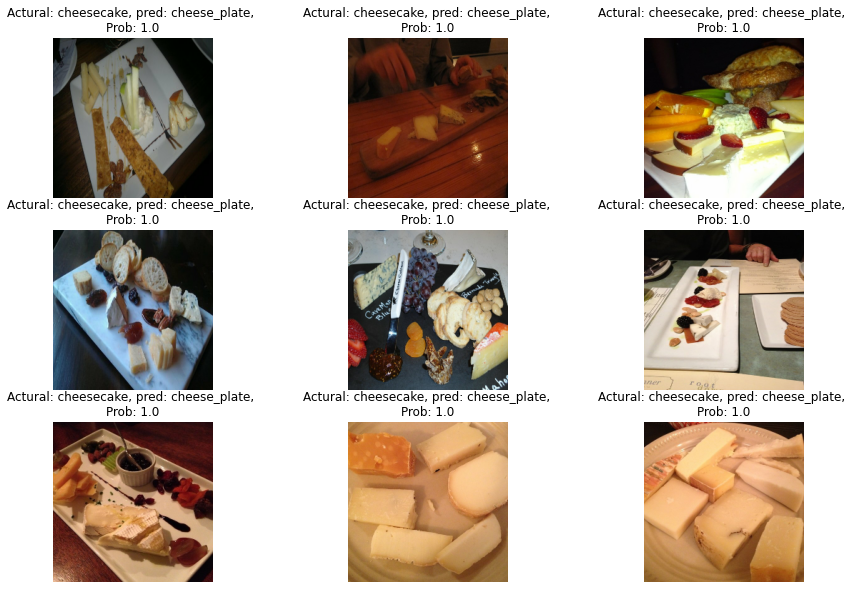

In [ ]:
image_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(cheese_cake[start_index:start_index+image_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _,_,_,_,pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"Actural: {y_true_classname}, pred: {y_pred_classname}, \nProb: {pred_prob}")
  plt.axis(False)

I think the cheesecake and cheese_plate is mislabeled. If those are right, the prediction will be better. However, I used downloaded test_data from the Daniel's github page used in section 06 for 10% of the food101 data. I couldn't figure out to use to predict from the test data from the tensorflow datasets. It could be the error when Daniel made the test datasets for 10% dataset. 

## Train with data augmentation

In [ ]:
# load weights
loaded_gs_model.load_weights(checkpoint_path_1)

In [ ]:
result = loaded_gs_model.evaluate(test_data)
result

790/790 [==============================] - 47s 59ms/step - loss: 1.0850 - accuracy: 0.7082


[1.0850051641464233, 0.7081980109214783]

In [ ]:
# Create data augmentation
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2)
], name="data_augmentation")

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
# Create model with data_augmentation
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(len(class_names), name="Dense_layer")(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
data_aug_model = tf.keras.Model(inputs, outputs)

data_aug_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

In [ ]:
data_aug_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
Dense_layer (Dense)          (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in data_aug_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_3 True float32 <Policy "mixed_float16">
Dense_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Create checkpoint
checkpoint_path_3 = "model_checkpoint/cp_3.ckpt"
data_aug_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_3,
                                                         monitor="val_acc",
                                                         save_best_only=True,
                                                         save_weights_only=False)

In [ ]:
history_aug_model = data_aug_model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15*len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                              experiment_name="data_augmentation_base_model"),
                                                  data_aug_checkpoint])

Saving TensorBoard log files to: training_logs/data_augmentation_base_model/20210707-042828
Epoch 1/3
2368/2368 [==============================] - 195s 79ms/step - loss: 2.6998 - accuracy: 0.3777 - val_loss: 1.4130 - val_accuracy: 0.6255


Epoch 2/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.7482 - accuracy: 0.5597 - val_loss: 1.2767 - val_accuracy: 0.6562


Epoch 3/3
2368/2368 [==============================] - 170s 71ms/step - loss: 1.6190 - accuracy: 0.5876 - val_loss: 1.2367 - val_accuracy: 0.6655


In [ ]:
data_aug_results = data_aug_model.evaluate(test_data)
data_aug_results

790/790 [==============================] - 47s 60ms/step - loss: 1.2594 - accuracy: 0.6602


[1.2593623399734497, 0.6601980328559875]

In [ ]:
data_aug_model.save("EfficientNetB0_data_aug_base_model.h5")

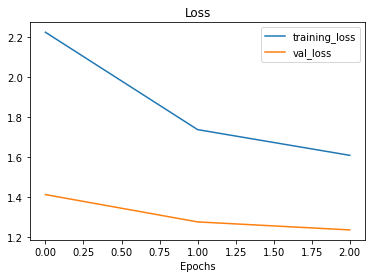

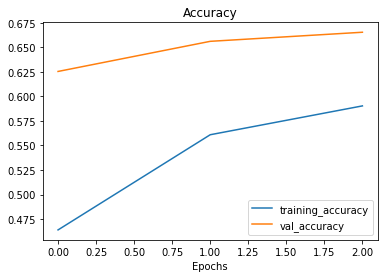

In [ ]:
plot_loss_curves(history_aug_model)

Make all the layer trainable and fit from the base_model

Create another checkpoint

In [ ]:
# Create checkpoint
checkpoint_path_4 = "model_checkpoint/cp_4.ckpt"
checkpoint_callbacks_4 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_4,
                                                            monitor="val_acc",
                                                            save_best_only=True, 
                                                            save_weights_only=True)

In [ ]:
# make all the layers trainable
base_model.trainable = True

for layer in data_aug_model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling2d_3 True
Dense_layer True
softmax_float32 True


In [ ]:
# Compile the model with learning rate 0.0001
data_aug_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       metrics=['accuracy'])

In [ ]:
history_aug_model_fine_tune = data_aug_model.fit(train_data,
                                                 epochs=100,
                                                 steps_per_epoch=len(train_data),
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15*len(test_data)),
                                                 initial_epoch=2,
                                                 callbacks=[checkpoint_callbacks_4,
                                                            earlystopping_callbacks,
                                                            create_tensorboard_callback("training_logs",
                                                                                        "data_aug_model_fine_tune_1")])

Saving TensorBoard log files to: training_logs/data_aug_model_fine_tune_1/20210707-044521
Epoch 3/100
2368/2368 [==============================] - 549s 226ms/step - loss: 1.3545 - accuracy: 0.6481 - val_loss: 0.9695 - val_accuracy: 0.7415


Epoch 4/100
2368/2368 [==============================] - 367s 154ms/step - loss: 0.9902 - accuracy: 0.7343 - val_loss: 0.8880 - val_accuracy: 0.7497


Epoch 5/100
2368/2368 [==============================] - 332s 140ms/step - loss: 0.8239 - accuracy: 0.7717 - val_loss: 0.8978 - val_accuracy: 0.7503


Epoch 6/100
2368/2368 [==============================] - 323s 136ms/step - loss: 0.7024 - accuracy: 0.8037 - val_loss: 0.9538 - val_accuracy: 0.7368


Epoch 7/100
2368/2368 [==============================] - 318s 134ms/step - loss: 0.5978 - accuracy: 0.8290 - val_loss: 0.8529 - val_accuracy: 0.7728


Epoch 8/100
2368/2368 [==============================] - 315s 132ms/step - loss: 0.4985 - accuracy: 0.8559 - val_loss: 0.9058 - val_accuracy: 0.7635


Epoch 9/100
2368/2368 [==============================] - 313s 132ms/step - loss: 0.4280 - accuracy: 0.8724 - val_loss: 0.9881 - val_accuracy: 0.7450


Epoch 10/100
2368/2368 [==============================] - 312s 131ms/step - loss: 0.3722 - accuracy: 0.8880 - val_loss: 0.9795 - val_accuracy: 0.7526


In [ ]:
data_aug_model.save("EfficientNetB0_data_aug_fine_tuning_1.h5")

In [ ]:
results_data_aug_fine_tune = data_aug_model.evaluate(test_data)
results_data_aug_fine_tune

790/790 [==============================] - 47s 60ms/step - loss: 0.9771 - accuracy: 0.7564


[0.9771486520767212, 0.7563960552215576]

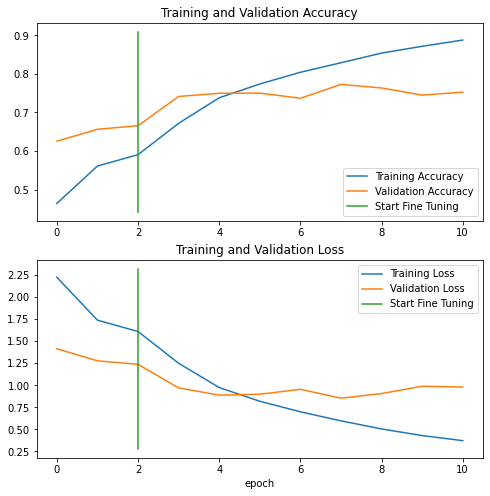

In [ ]:
compare_historys(history_aug_model, history_aug_model_fine_tune,initial_epochs=3)

## Use saved model to predict and visualize them
`big_data_efficientnetb0_fine_tune.h5` - This model is from the course. 

790/790 [==============================] - 47s 60ms/step - loss: 1.1443 - accuracy: 0.7684

[1.1443232297897339, 0.7684356570243835]

`EfficientNetB0_data_aug_fine_tuning_1.h5` - The model fine-tuned with data_augmentation. 

790/790 [==============================] - 47s 60ms/step - loss: 0.9771 - accuracy: 0.7564

[0.9771486520767212, 0.7563960552215576]

It was not I was expected. It was worth score with augmented data. It might work better with small data not the full data. I will do few more experiment with data augmentation. However,  couldn't save checkpoint because the score was not the best. 

## What about other feature extraction model?

I will make onother notebook then try with other feature extraction model then compare with this EfficientNetB0. 